# Import Data

In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

  0%|          | 0/141 [00:00<?, ?it/s]

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...
Finished loading INFO


100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


In [5]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

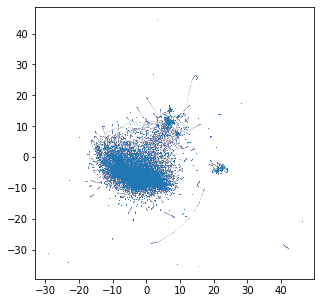

In [6]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_kinematic_embed[:,0], all_kinematic_embed[:,1], s=1, alpha=0.005)
plt.show()

# Quick Overview

In [7]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

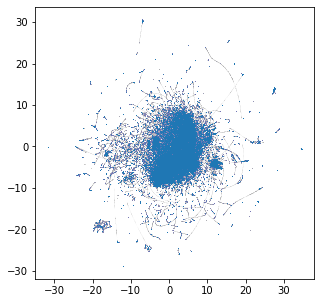

In [7]:
region_x_lim, region_y_lim = (-7,2), (-10,5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=2, alpha=0.006)
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

# Power Map on Embedding

In [8]:
import seaborn as sns

In [9]:
max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] # Nyquist Frequency
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1)) # dyadic frequency bins

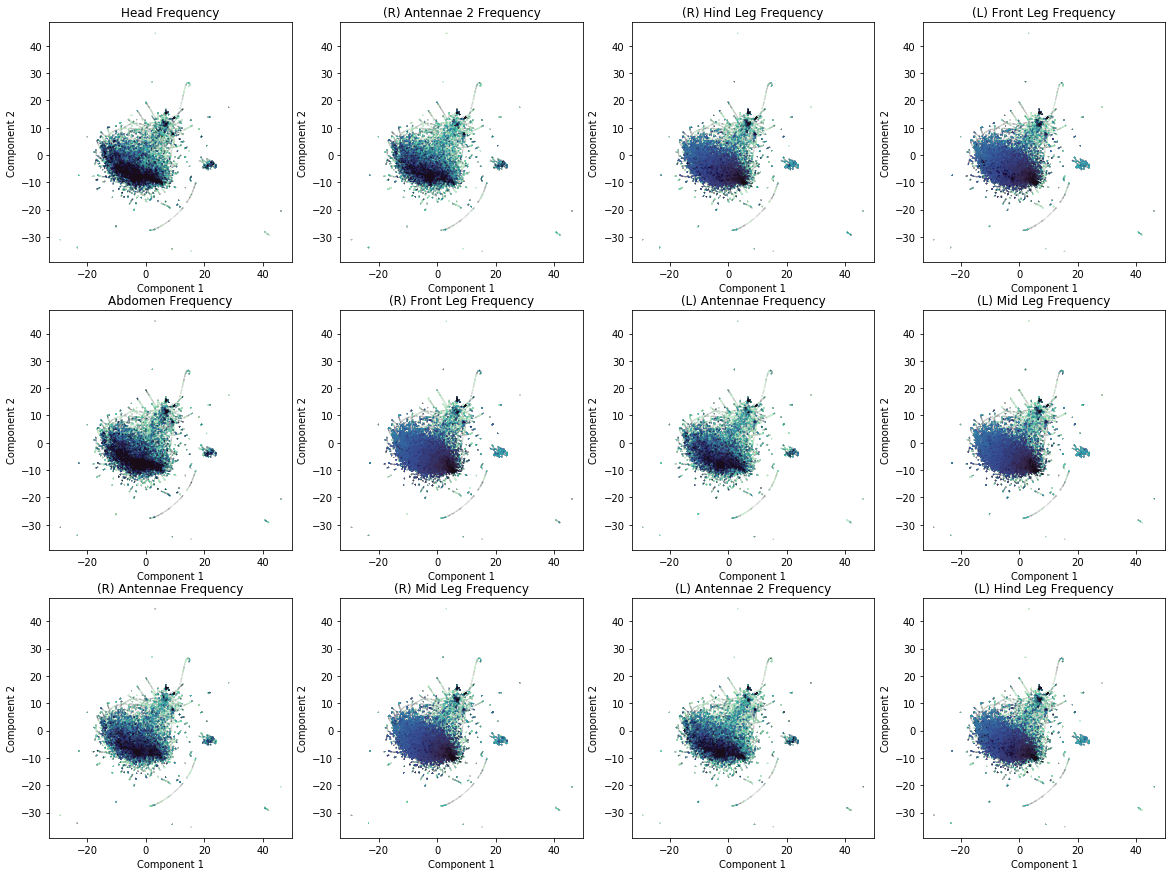

In [10]:
# Figure Information
max_freq_idx = np.argmax(angle_power[:,:,:], axis=1)
max_freq = freq[max_freq_idx]
num_freq = len(freq)

# Freq Color Scheme
freq_color_palette = sns.color_palette('mako_r', num_freq)
cmap1, norm1 = matplotlib.colors.from_levels_and_colors(freq, freq_color_palette, extend="max")

# Figures
fig, ax = plt.subplots(3,4, figsize=(20,15))
for angle_idx in tqdm(range(12)):
    fig_title = f"{config['angle_labels'][angle_idx]} Frequency"
    freq_cluster_colors = np.array([freq_color_palette[f] for f in max_freq_idx[:,angle_idx]])

    ax[angle_idx%3, angle_idx//3].scatter(all_kinematic_embed[:,0], all_kinematic_embed[:,1], color=freq_cluster_colors, alpha=0.005, s=1.5)  
    ax[angle_idx%3, angle_idx//3].set(xlabel='Component 1', ylabel='Component 2', title=fig_title) # xlim=region_x_lim, ylim=region_y_lim

plt.show()

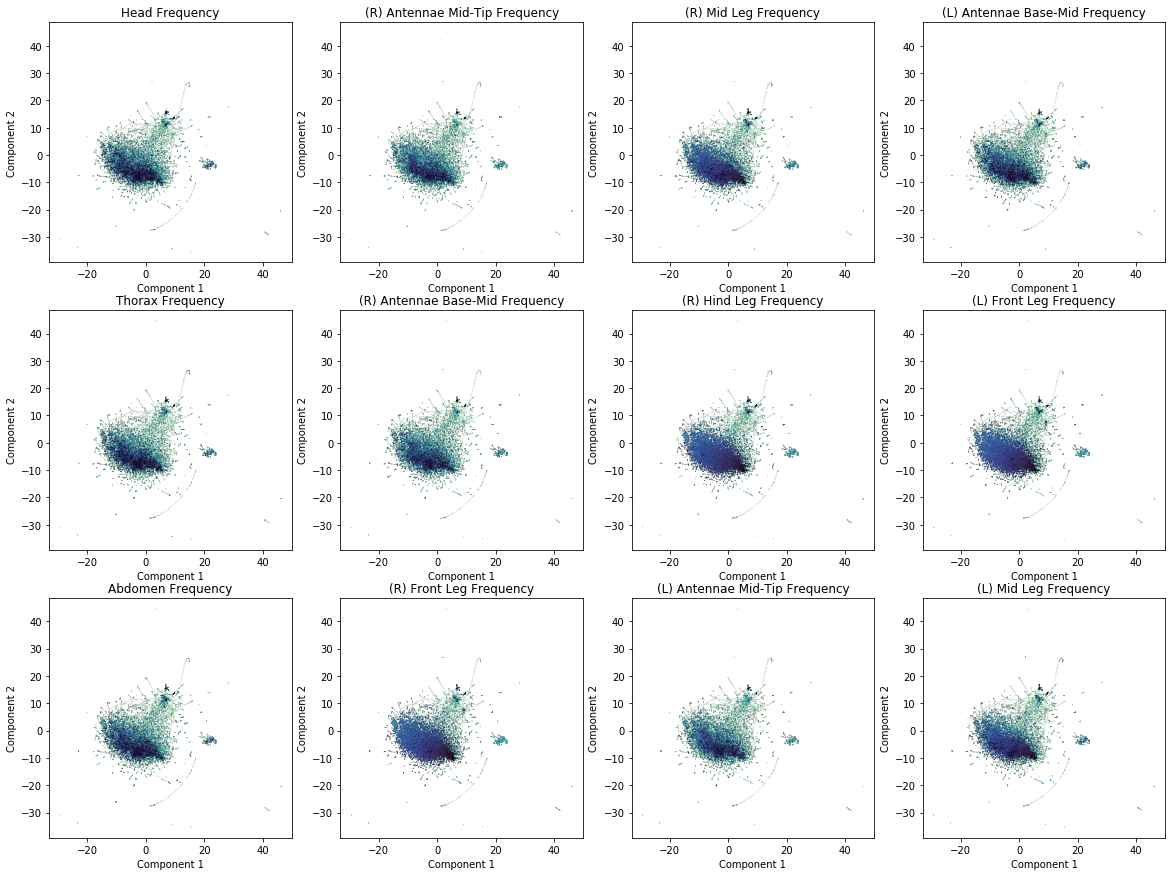

In [11]:
# Figure Information
max_freq_idx = np.argmax(limb_power[:,:,:], axis=1)
max_freq = freq[max_freq_idx]
num_freq = len(freq)

# Freq Color Scheme
freq_color_palette = sns.color_palette('mako_r', num_freq)
cmap1, norm1 = matplotlib.colors.from_levels_and_colors(freq, freq_color_palette, extend="max")

# Figures
fig, ax = plt.subplots(3,4, figsize=(20,15))
for limb_idx in tqdm(range(12)):
    fig_title = f"{config['limb_labels'][limb_idx]} Frequency"
    freq_cluster_colors = np.array([freq_color_palette[f] for f in max_freq_idx[:,limb_idx]])

    ax[limb_idx%3, limb_idx//3].scatter(all_kinematic_embed[:,0], all_kinematic_embed[:,1], color=freq_cluster_colors, alpha=0.005, s=0.5)  
    ax[limb_idx%3, limb_idx//3].set(xlabel='Component 1', ylabel='Component 2', title=fig_title) #, xlim=region_x_lim, ylim=region_y_lim
plt.show()

# Checking Kinematic/Postural Scaling

In [14]:
angle_pk_scale = np.max(angle_power, axis=(0,1))/np.max(angles, axis=(0))
limb_pk_scale = np.max(limb_power, axis=(0,1))/np.max(limbs, axis=(0))
adj_angles = angles*angle_pk_scale
adj_limbs = limbs*limb_pk_scale

In [15]:
angle_pk_scale

array([1.52019597, 1.60983968, 0.65329098, 0.70926514, 0.71802813,
       0.72927972, 0.65901491, 0.65735366, 0.65924177, 0.69263601,
       0.8200092 , 0.70475136])

In [16]:
limb_pk_scale

array([2.12811374, 1.92606646, 2.11270275, 2.07522934, 2.08900823,
       2.07736683, 2.06540107, 2.42159542, 2.2445999 , 2.20377784,
       2.22939808, 2.15060295, 2.14910714])

In [19]:
np.max(angle_power, axis=(0,1))

array([4.77436547, 5.05590274, 4.10348394, 4.45507167, 4.51011416,
       4.58078822, 4.1394374 , 4.1290027 , 4.14086234, 4.35061993,
       5.15068282, 4.42671947])

In [21]:
np.max(angles, axis=(0))

array([3.140625, 3.140625, 6.28125 , 6.28125 , 6.28125 , 6.28125 ,
       6.28125 , 6.28125 , 6.28125 , 6.28125 , 6.28125 , 6.28125 ])

In [22]:
limb_power.shape

(1872138, 20, 13)

# Watershed Clustering

In [12]:
from cluster import Watershed
from sklearn.utils import shuffle
%load_ext autoreload
%autoreload 1
%aimport cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Creating 2D Grid System...(1/7)
Computing Gaussian Kernel...(2/7)
Finding Data Point Coordinates...(3/7)
Finding Local Max Basin Point...(4/7)
Creating Mask...(5/7)
Finding Watershed...(6/7)
Creating Watershed label...(7/7)
COMPLETE


/Users/donghur/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


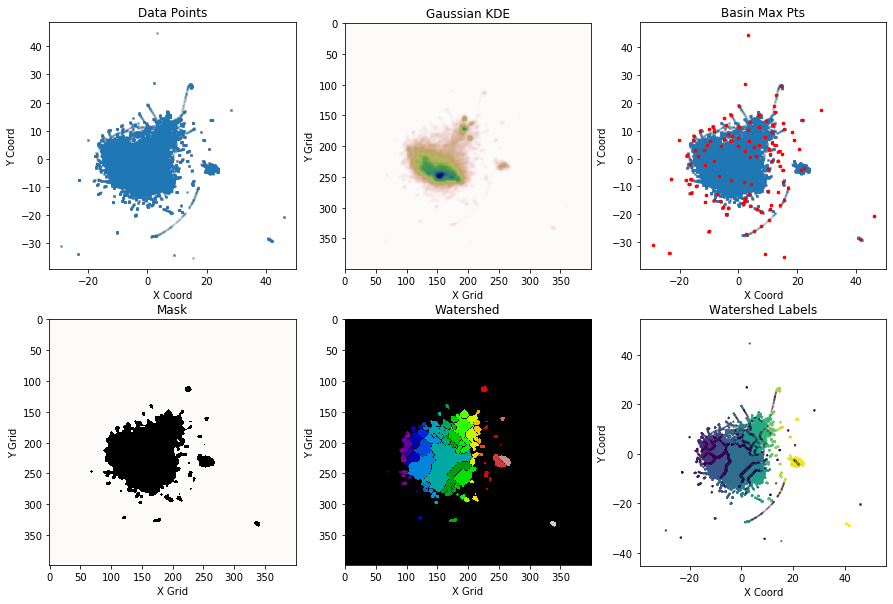

111.0


In [36]:
num_fr, num_dim = all_kinematic_embed.shape
nan_fr, nan_dim = np.where(np.isnan(all_kinematic_embed))
np_unique_fr = np.unique(nan_fr)
good_fr = np.array([True]*num_fr)
good_fr[np_unique_fr] = False

good_all_embed = all_kinematic_embed[good_fr]

watershed_labels = Watershed(data=good_all_embed, grid_dim=400, bw_method=0.12, ROI_thresh=0.0001, grid_padding=10, verbose=True, fig_alpha=0.01, fig_s=2, watershed_line=True)

print(np.max(watershed_labels)+1)

In [37]:
import os

full_label = np.ones(num_fr)*-1
full_label[good_fr] = watershed_labels

for val in INFO_values:
    start_fr, stop_fr = val['global_start_fr'], val['global_stop_fr']
    save_path = f"/Users/donghur/Desktop/Research/Murthy/BM_GPU/{val['directory']}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(f"{save_path}/kinematic_embedding_cluster.npy", full_label[start_fr:stop_fr])

In [42]:
np.where(full_label==1)

(array([], dtype=int64),)

# Power Spectrogram

In [16]:
import seaborn as sns
from sklearn.utils import shuffle

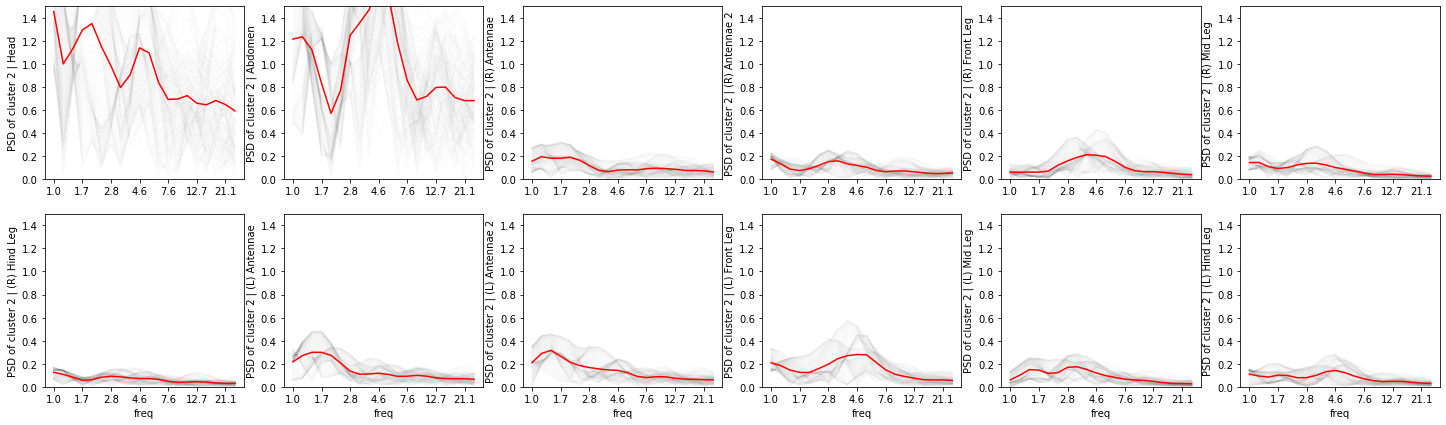

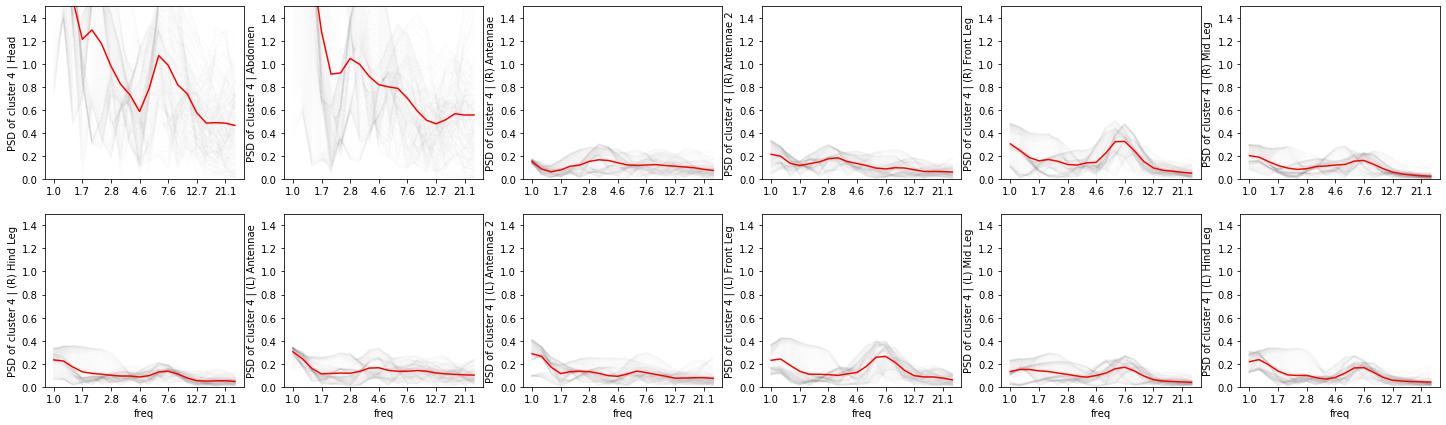

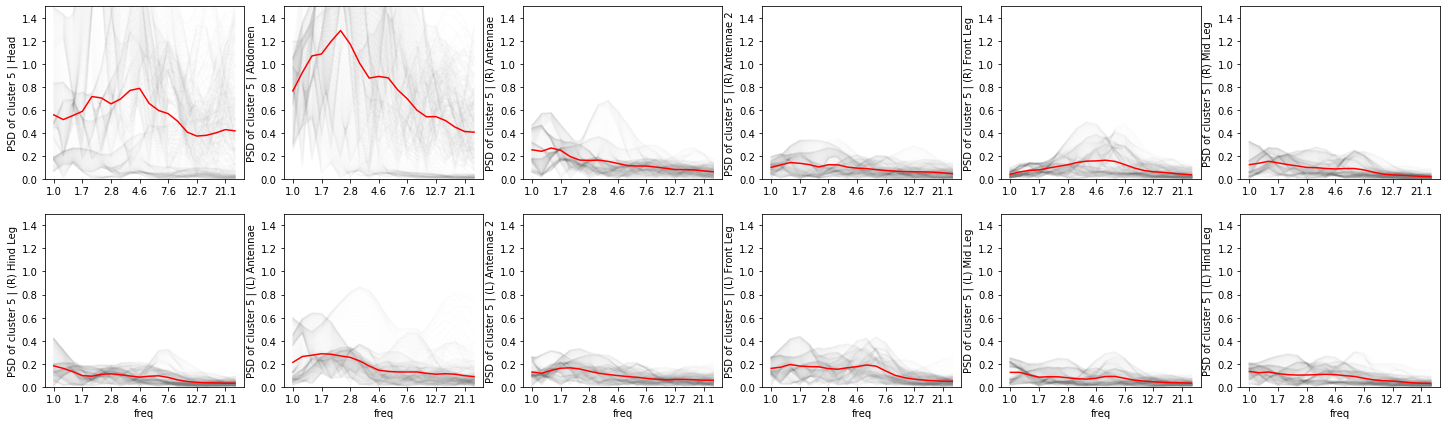

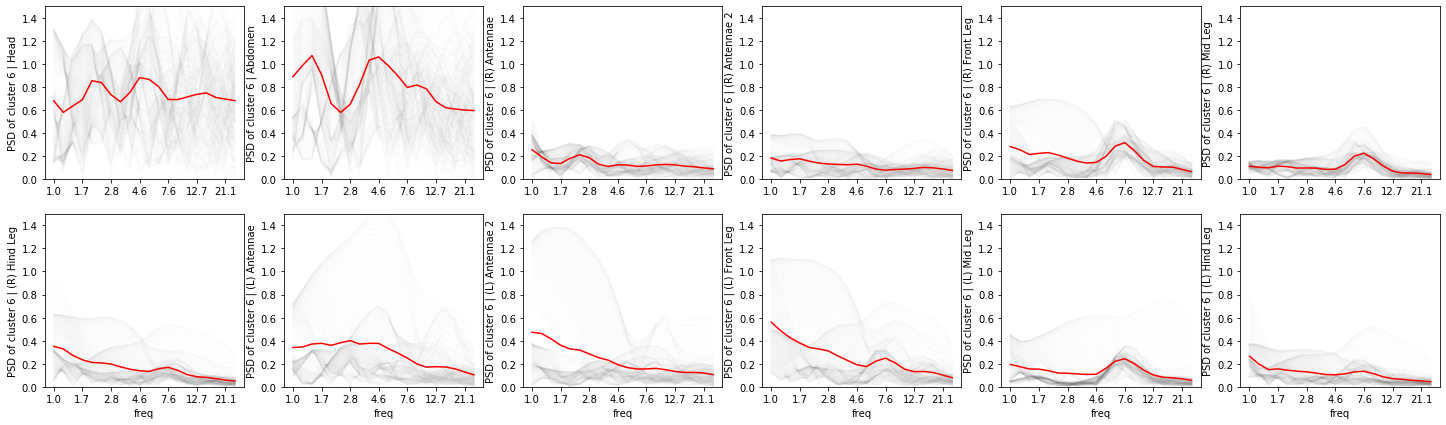

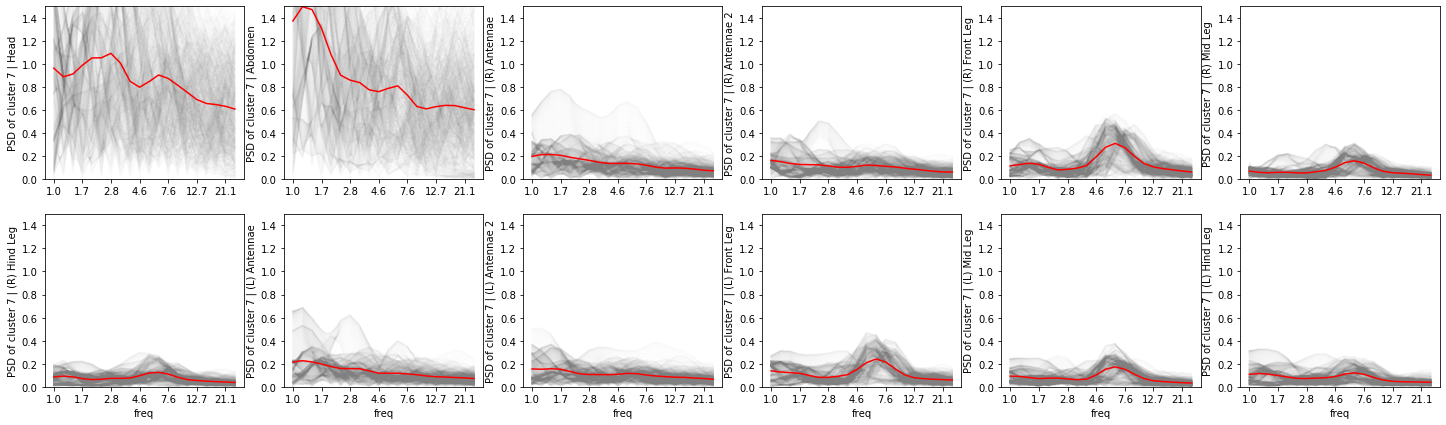

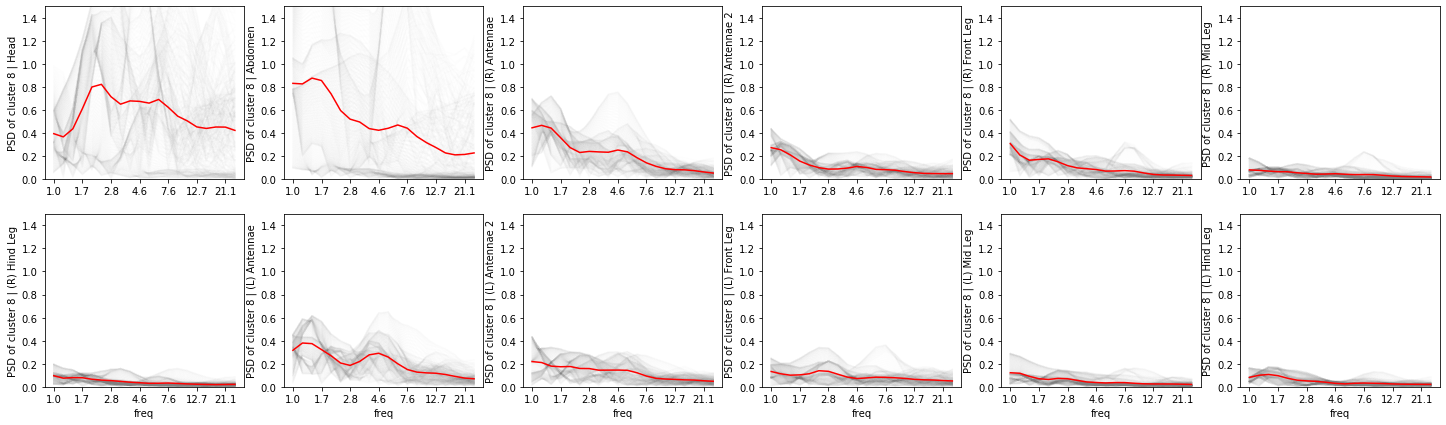

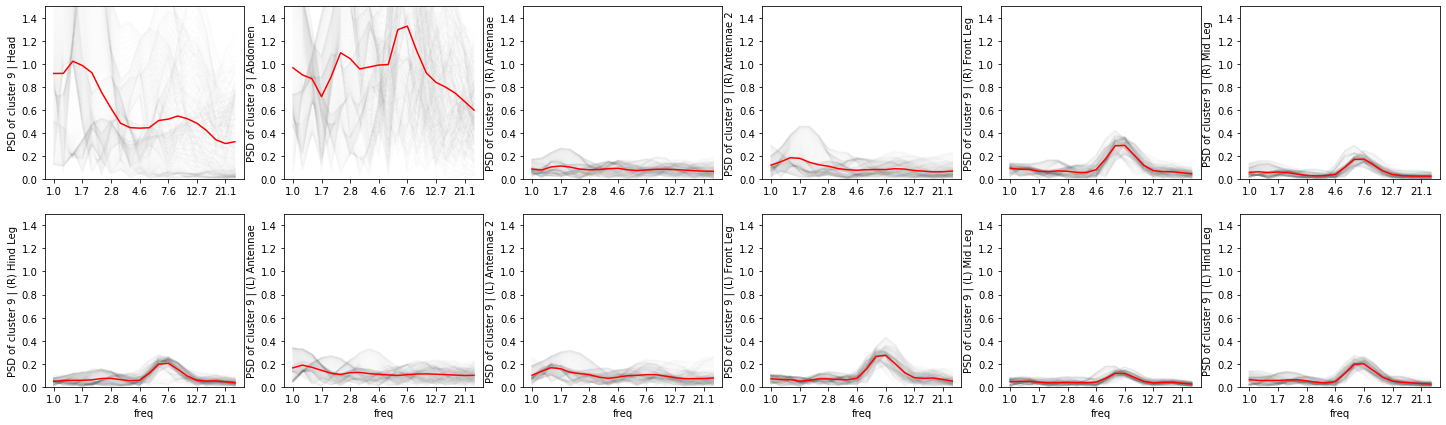

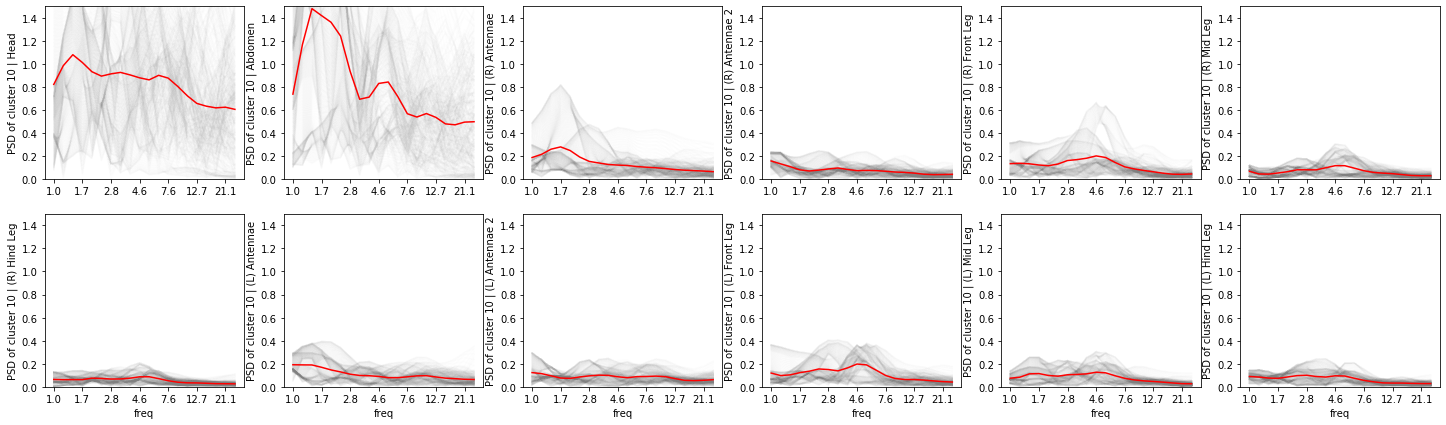

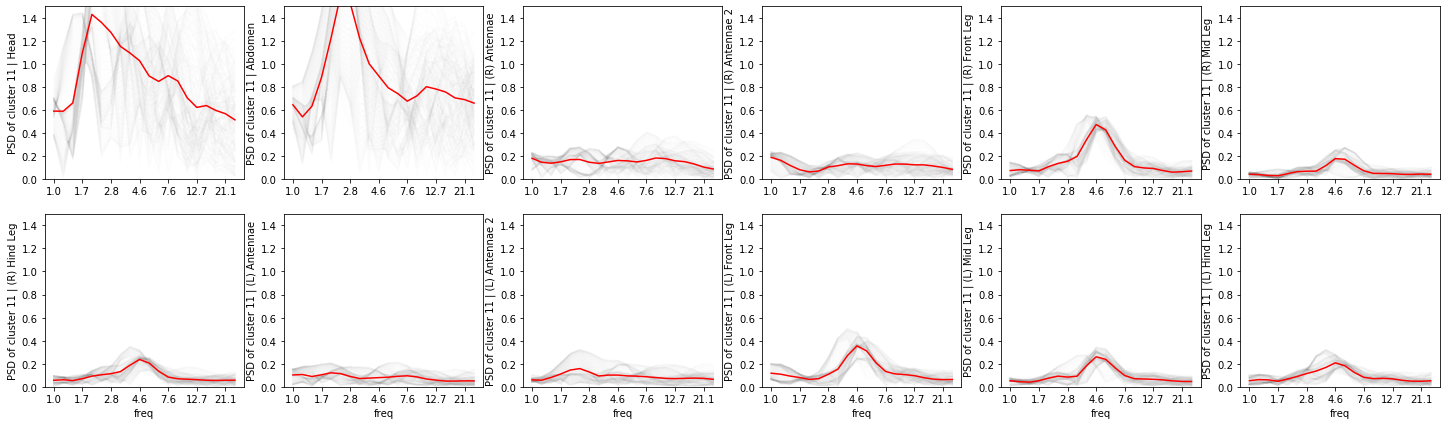

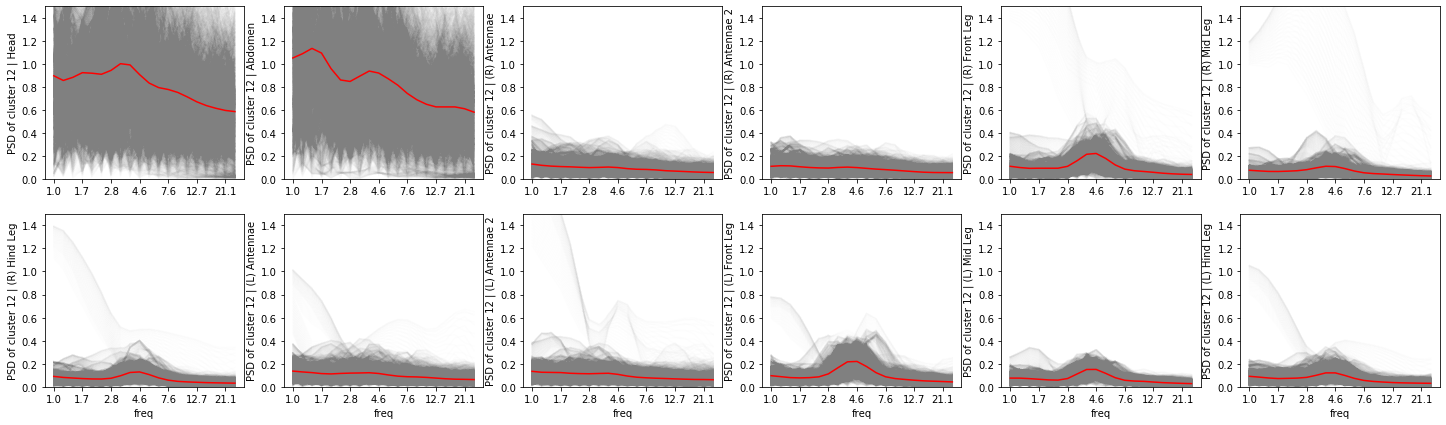

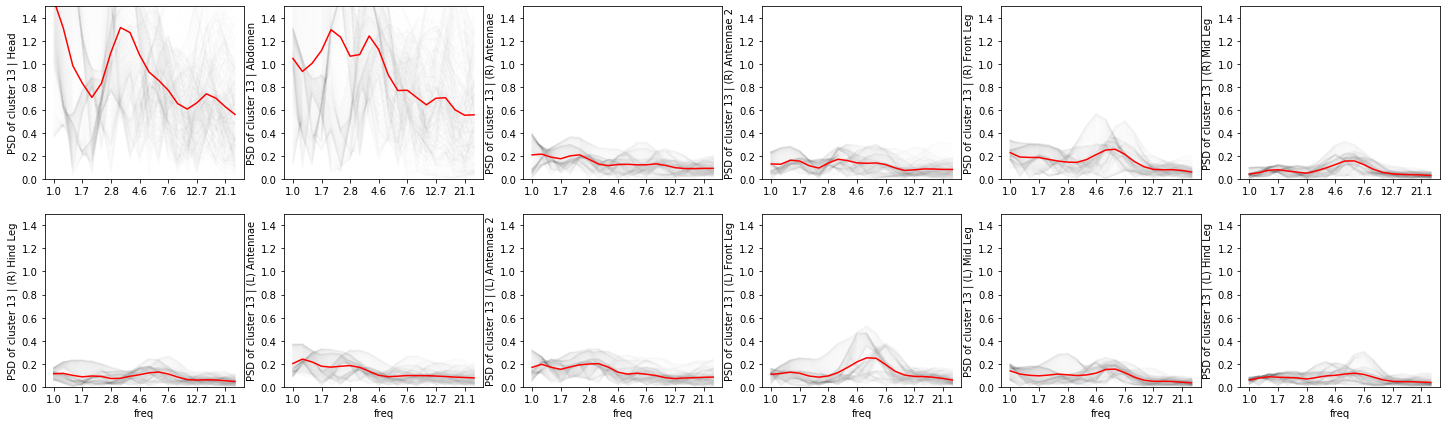

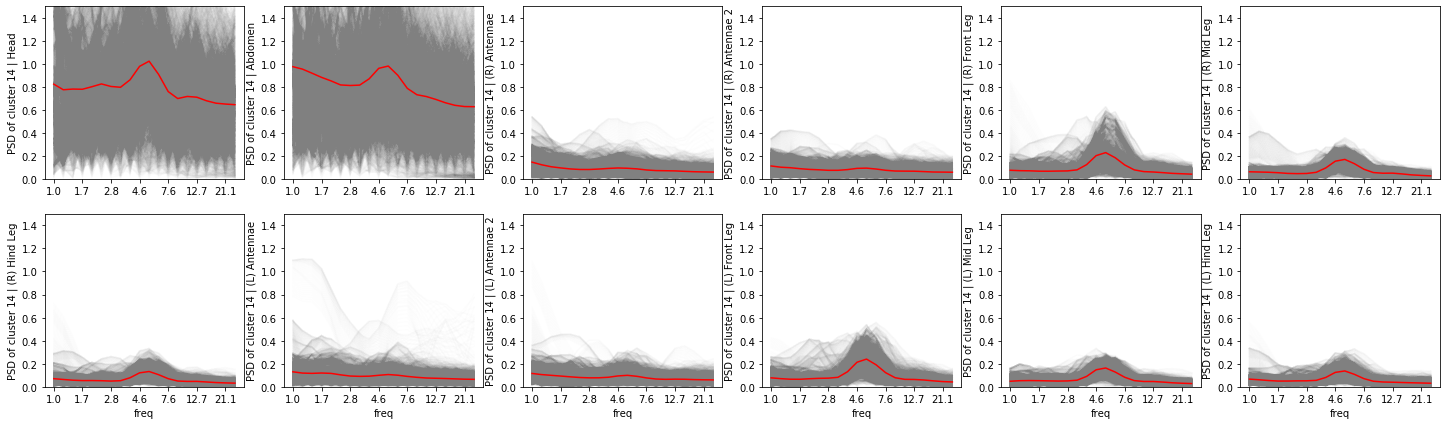

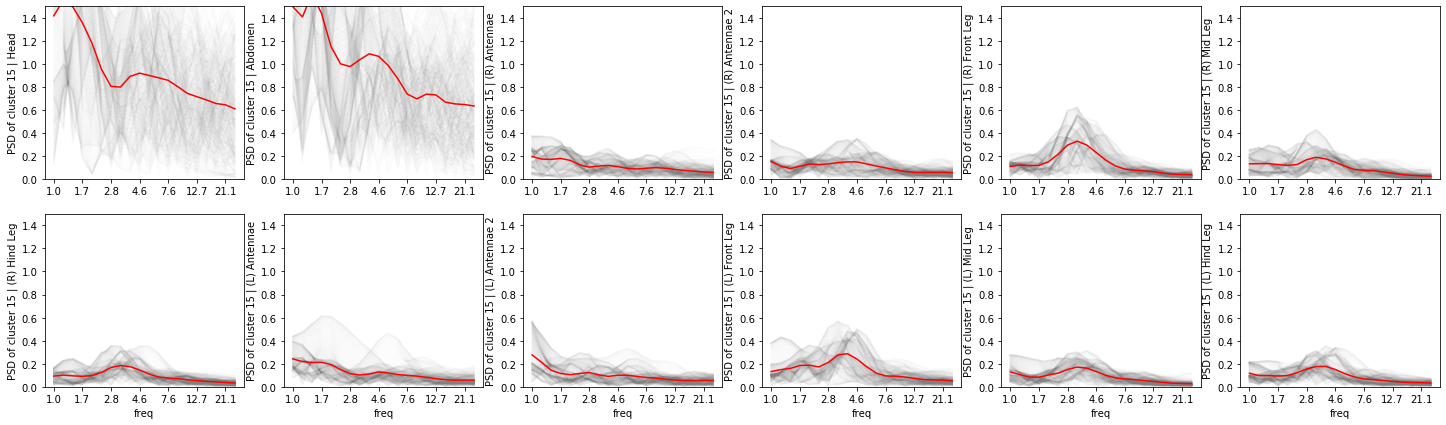

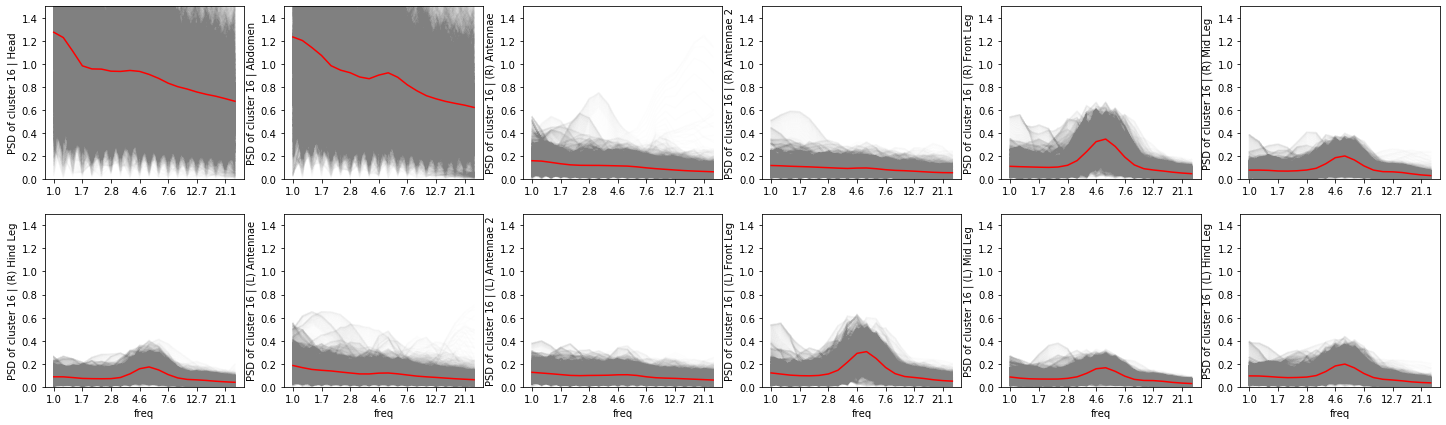

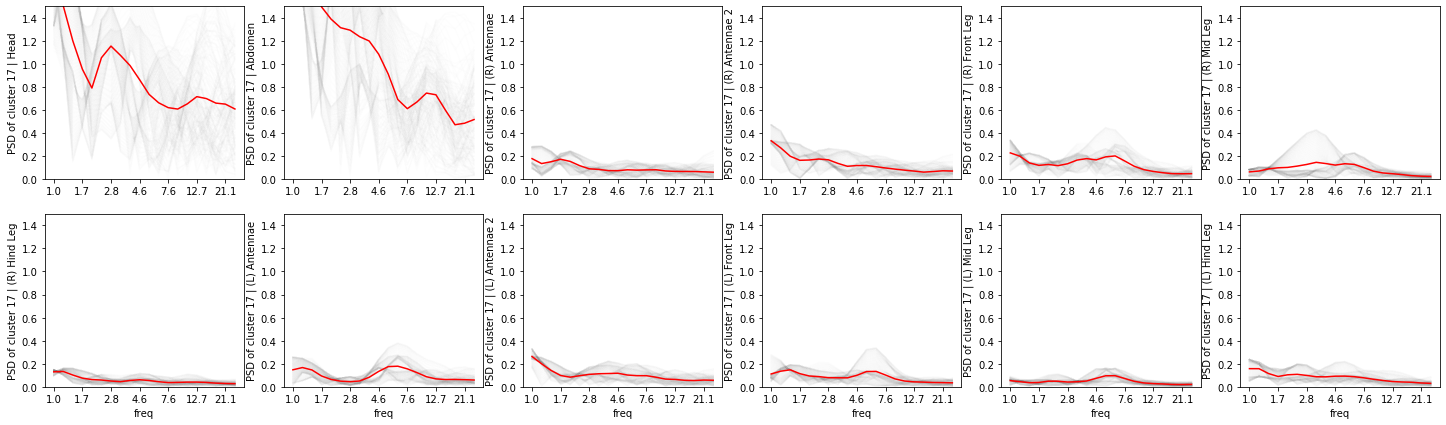

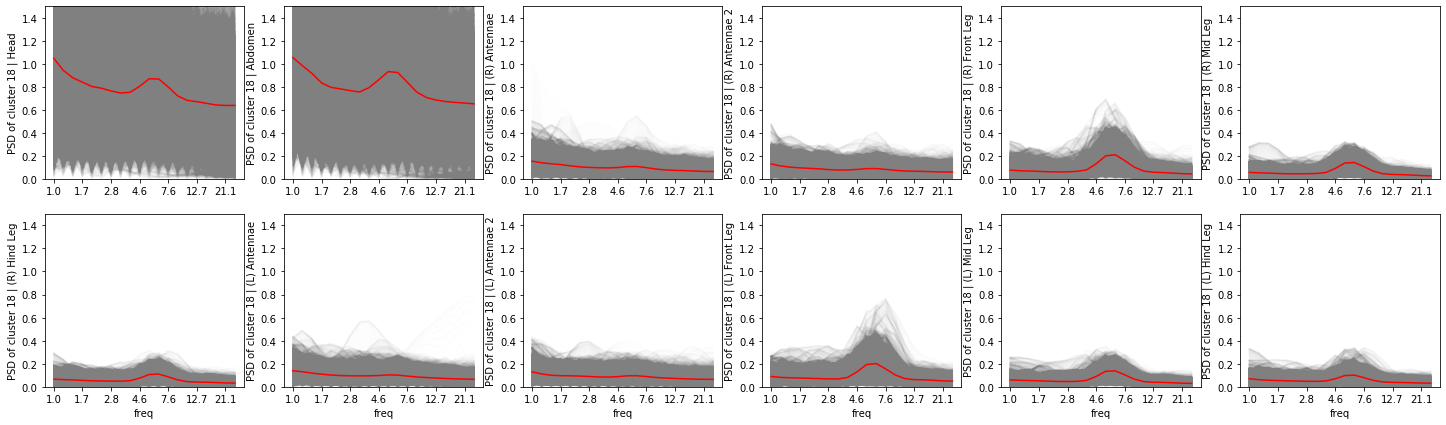

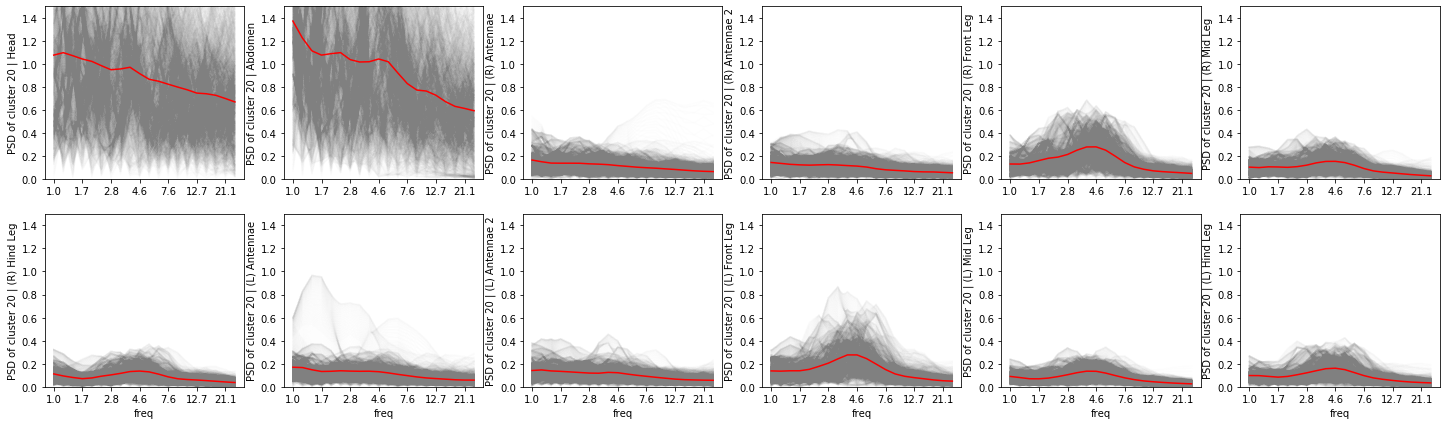

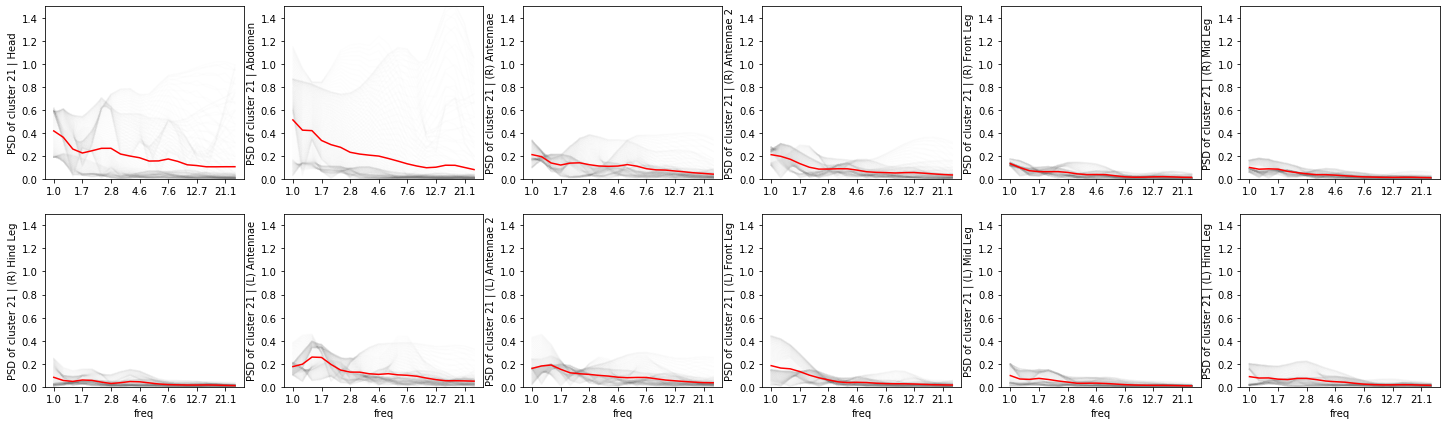

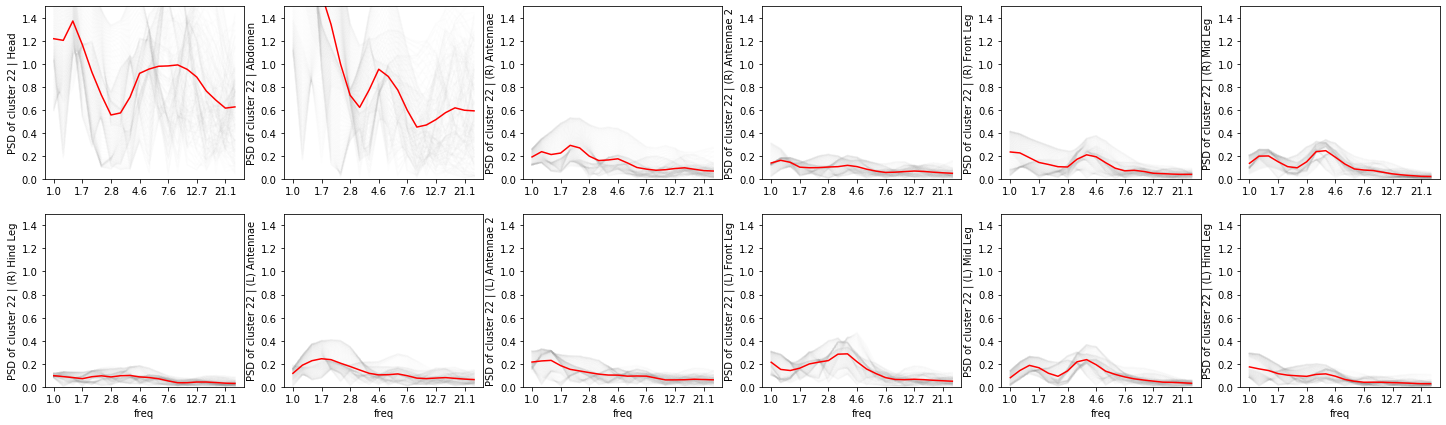

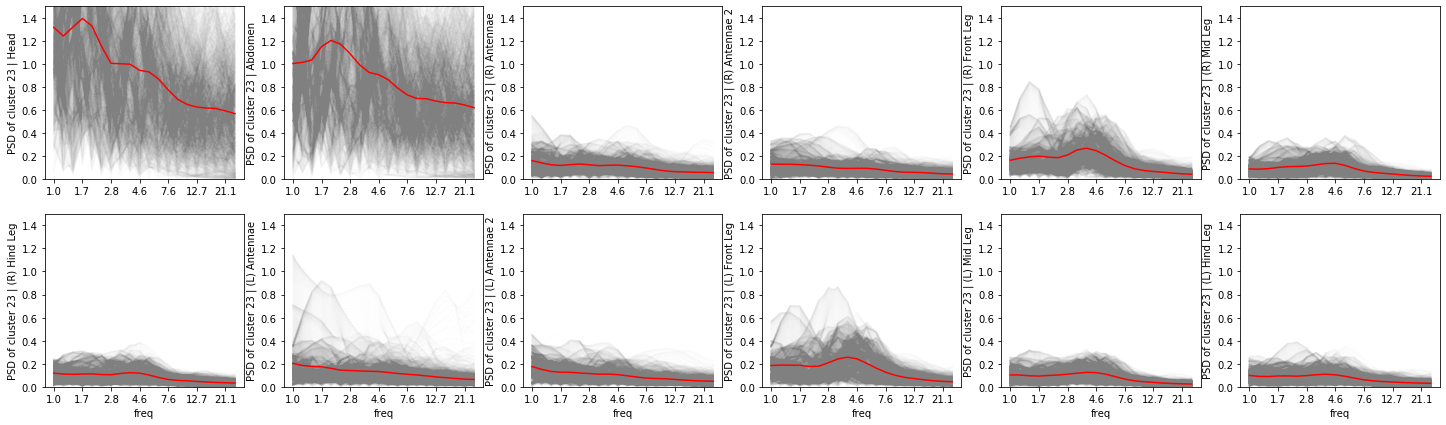

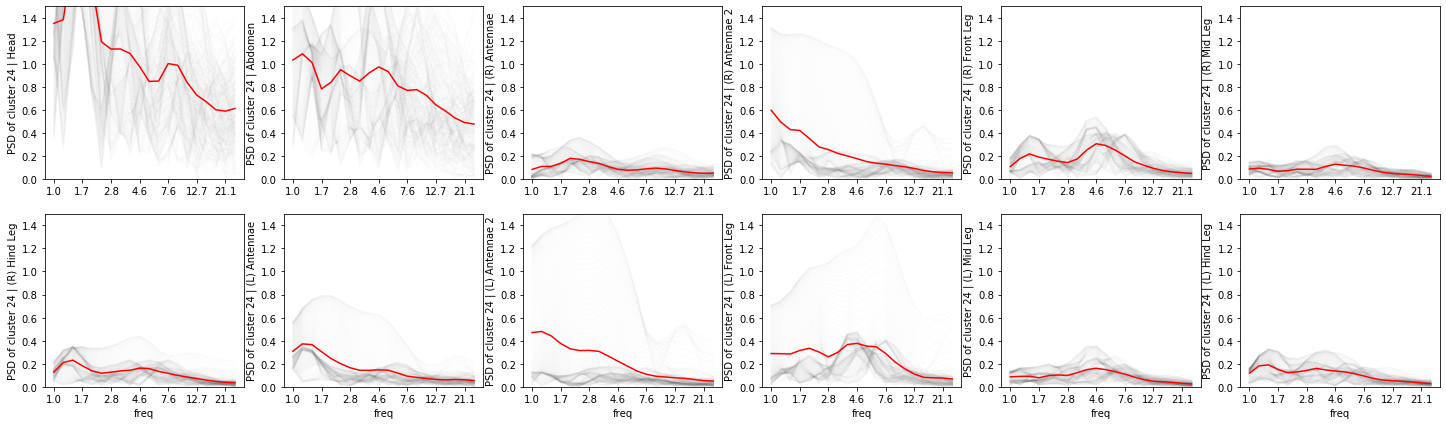

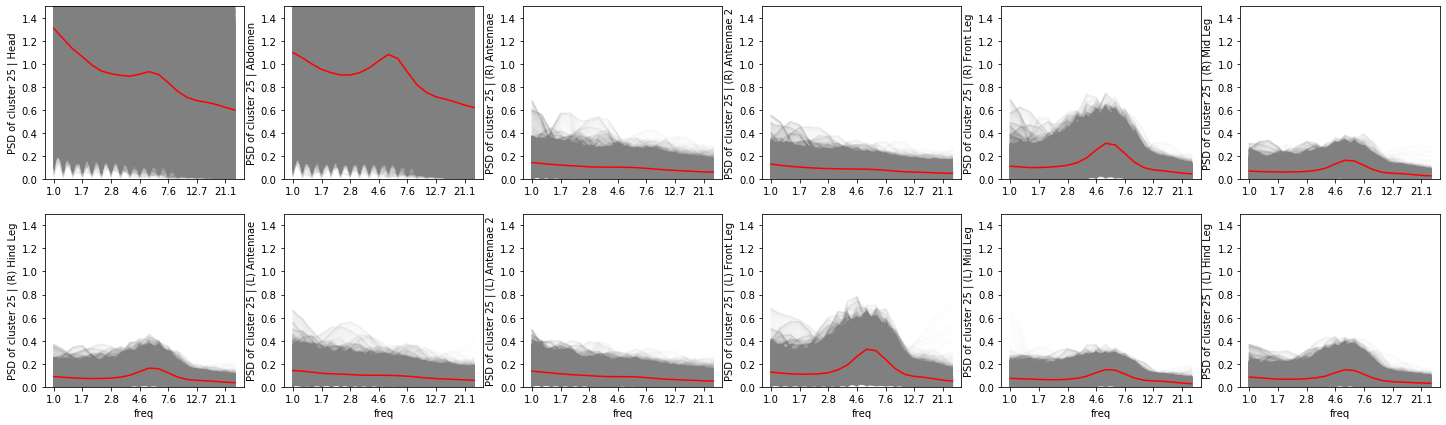

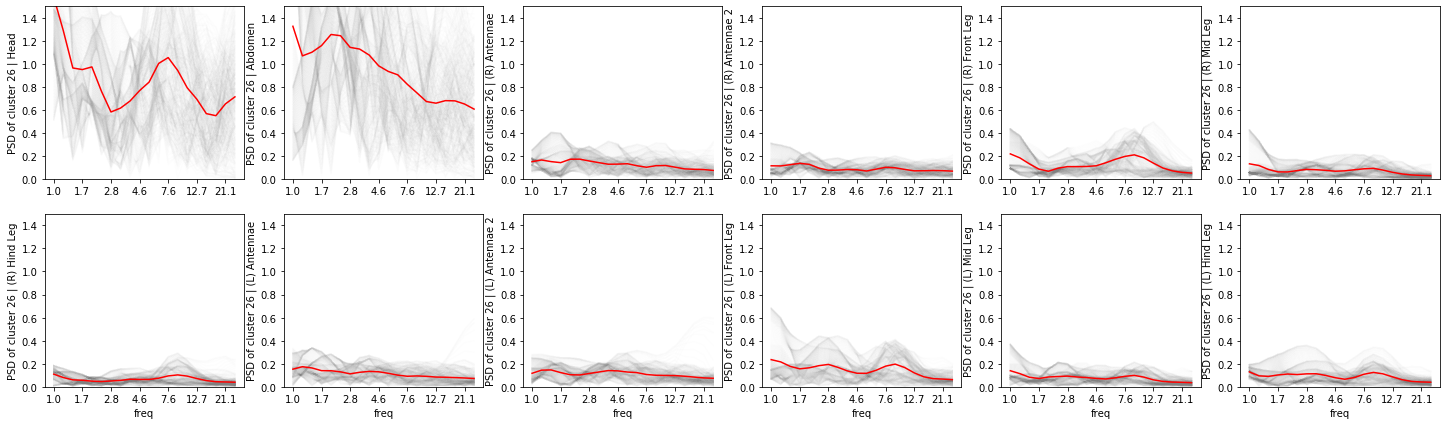

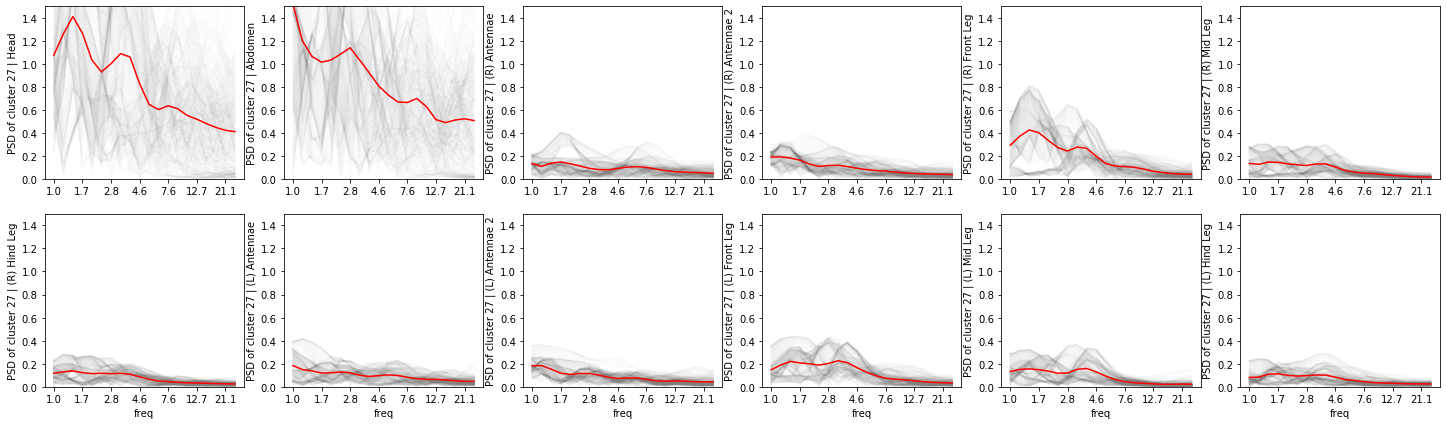

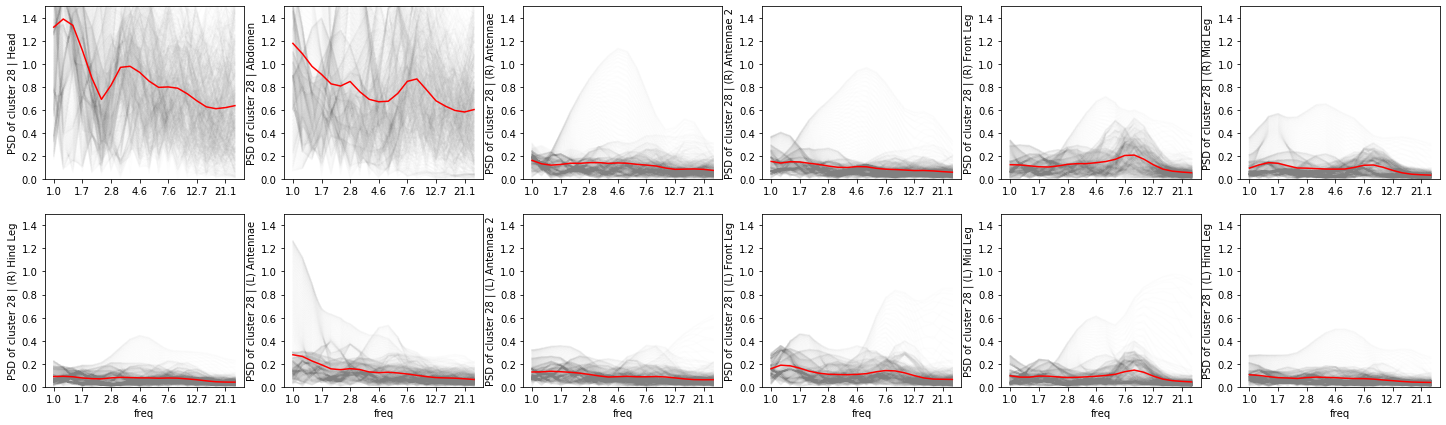

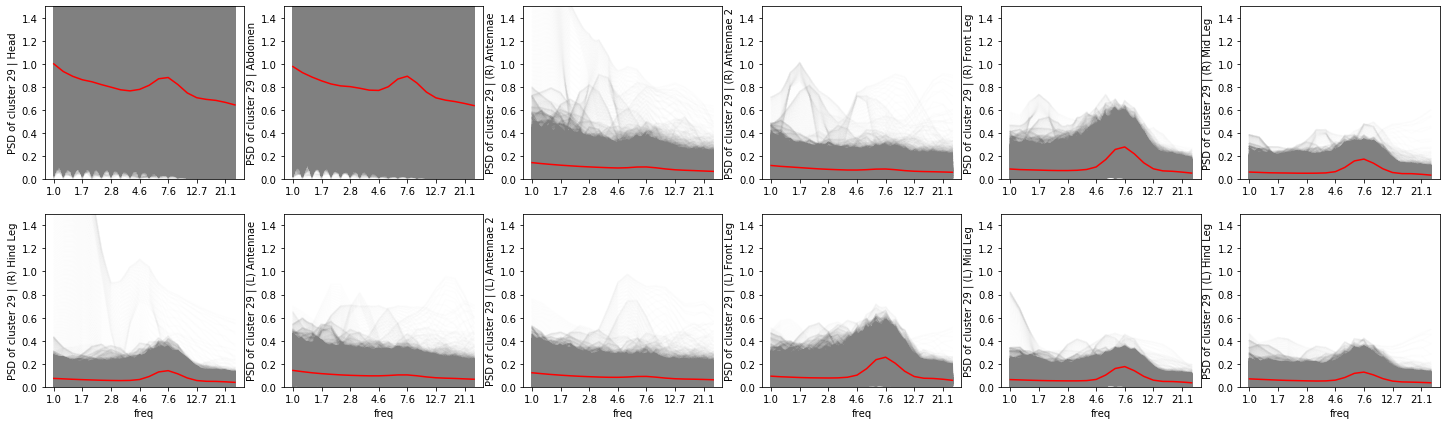

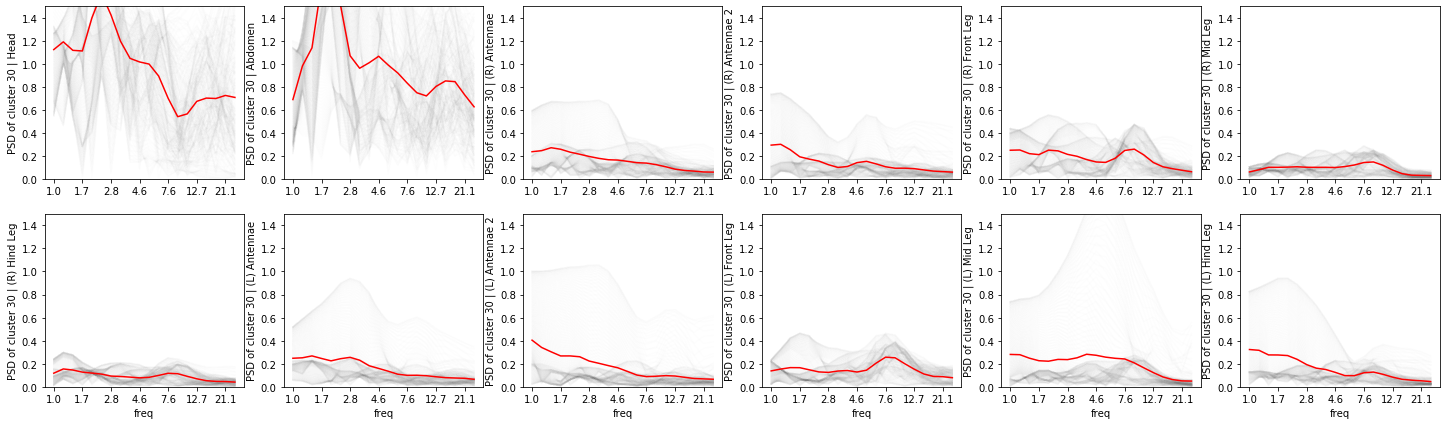

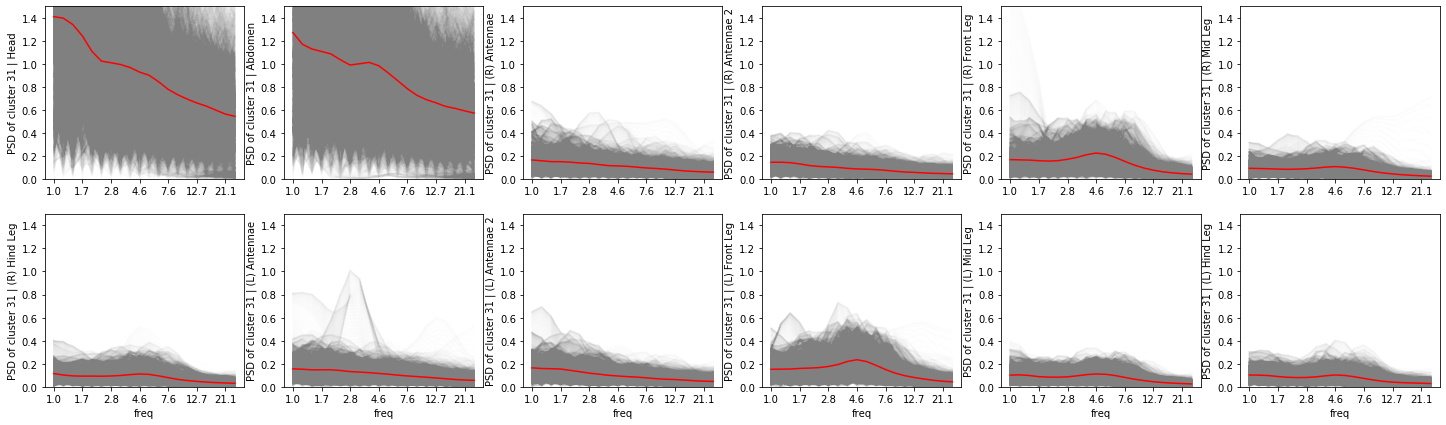

KeyboardInterrupt: 

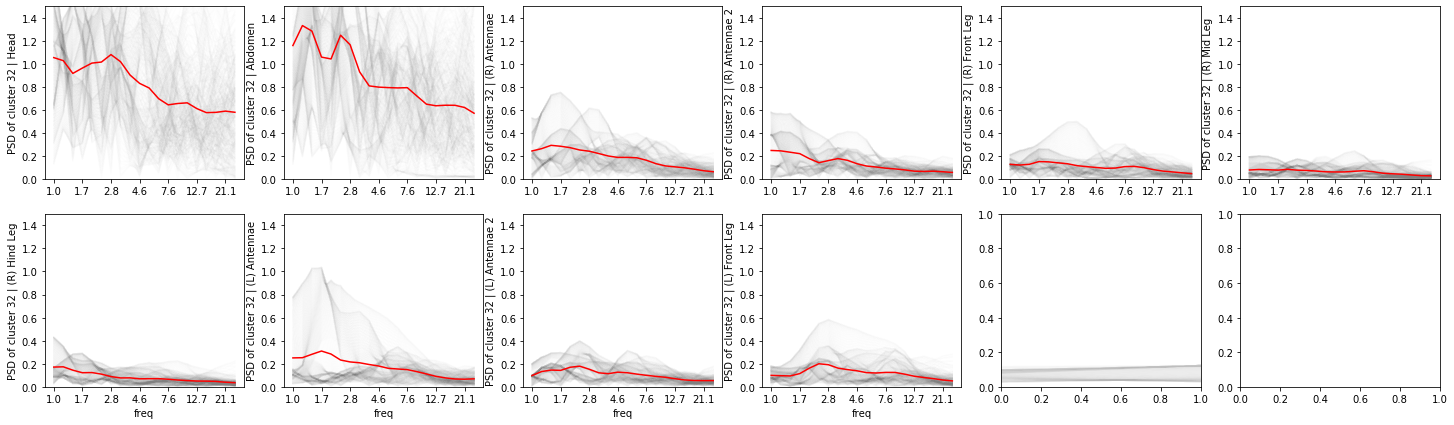

In [56]:
# matplotlib.rc('font', size=MEDIUM_SIZE)
# matplotlib.rc('axes', titlesize=MEDIUM_SIZE)
labels = full_label
num_fr, num_freq, num_angles = angle_power.shape
num_cluster = int(np.max(labels)+1)

max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] 
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))

for i_cluster in tqdm(range(num_cluster)):
    idx_cluster = np.where(labels == i_cluster)[0]
    if len(idx_cluster) != 0:
        fig, ax = plt.subplots(2,6,figsize=(25,7))
        for i_angle in range(num_angles): 
            ax[i_angle//6, i_angle%6].plot(angle_power[idx_cluster,:,i_angle].T, alpha=0.01, c='gray')
            ax[i_angle//6, i_angle%6].plot(np.mean(angle_power[idx_cluster,:,i_angle], axis=0).T, alpha=1, c='red')
            if i_angle//6 ==1:
                ax[i_angle//6, i_angle%6].set(xlabel='freq', ylabel=f"PSD of cluster {i_cluster} | {config['angle_labels'][i_angle]}",
                               ylim=[0,1.5], xticks=np.arange(len(freq))[::3], xticklabels=np.round(freq[::3],1))
            else:
                ax[i_angle//6, i_angle%6].set(ylabel=f"PSD of cluster {i_cluster} | {config['angle_labels'][i_angle]}",
                           ylim=[0,1.5], xticks=np.arange(len(freq))[::3], xticklabels=np.round(freq[::3],1))
        plt.show()

In [ ]:
num_fr, num_freq, num_limbs = limb_power.shape
num_cluster = int(np.max(labels)+1)

max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] 
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))

for i_cluster in range(num_cluster):
    idx_cluster = (labels == i_cluster)
    # plot
    fig, ax = plt.subplots(1,num_limbs,figsize=(num_limbs*5,2))
    for i_limb in range(num_limbs):
        ax[i_limb].plot(limb_power[idx_cluster,:,i_limb].T, alpha=0.01, c='gray')
        ax[i_limb].plot(np.mean(limb_power[idx_cluster,:,i_limb], axis=0).T, alpha=1, c='red')
        ax[i_limb].set(xlabel='freq', ylabel='power', title=f"PSD of cluster {i_cluster} | {config['limb_labels'][i_limb]}",
                       ylim=[0,1.5], xticks=np.arange(len(freq))[::3], xticklabels=np.round(freq[::3],1))
    plt.show()

# Caste

In [57]:
caste_data = {"min": [], "mid": [], "maj":[]}
env_data = {"food": [], "free":[]}

caste_cluster = {"min": [], "mid": [], "maj":[]}
env_cluster = {"food": [], "free": []}

cluster = full_label
for item in INFO_values:
    path = item['directory']
    start, stop = item['global_start_fr'], item['global_stop_fr']

    # Caste Condition
    if path.find("min") is not -1:
        caste_data["min"].extend(all_kinematic_embed[start:stop].tolist())
        caste_cluster["min"].extend(cluster[start:stop].tolist())
    if path.find("mid") is not -1:
        caste_data["mid"].extend(all_kinematic_embed[start:stop].tolist())
        caste_cluster["mid"].extend(cluster[start:stop].tolist())
    if path.find("maj") is not -1:
        caste_data["maj"].extend(all_kinematic_embed[start:stop].tolist())
        caste_cluster["maj"].extend(cluster[start:stop].tolist())
    
    # Environmental Conditions
    if path.find("fd") is not -1:
        env_data["food"].extend(all_kinematic_embed[start:stop].tolist())
        env_cluster["food"].extend(cluster[start:stop].tolist())
    if path.find("fr") is not -1:
        env_data["free"].extend(all_kinematic_embed[start:stop].tolist())
        env_cluster["free"].extend(cluster[start:stop].tolist())

(505934, 2)
(618586, 2)
(661457, 2)


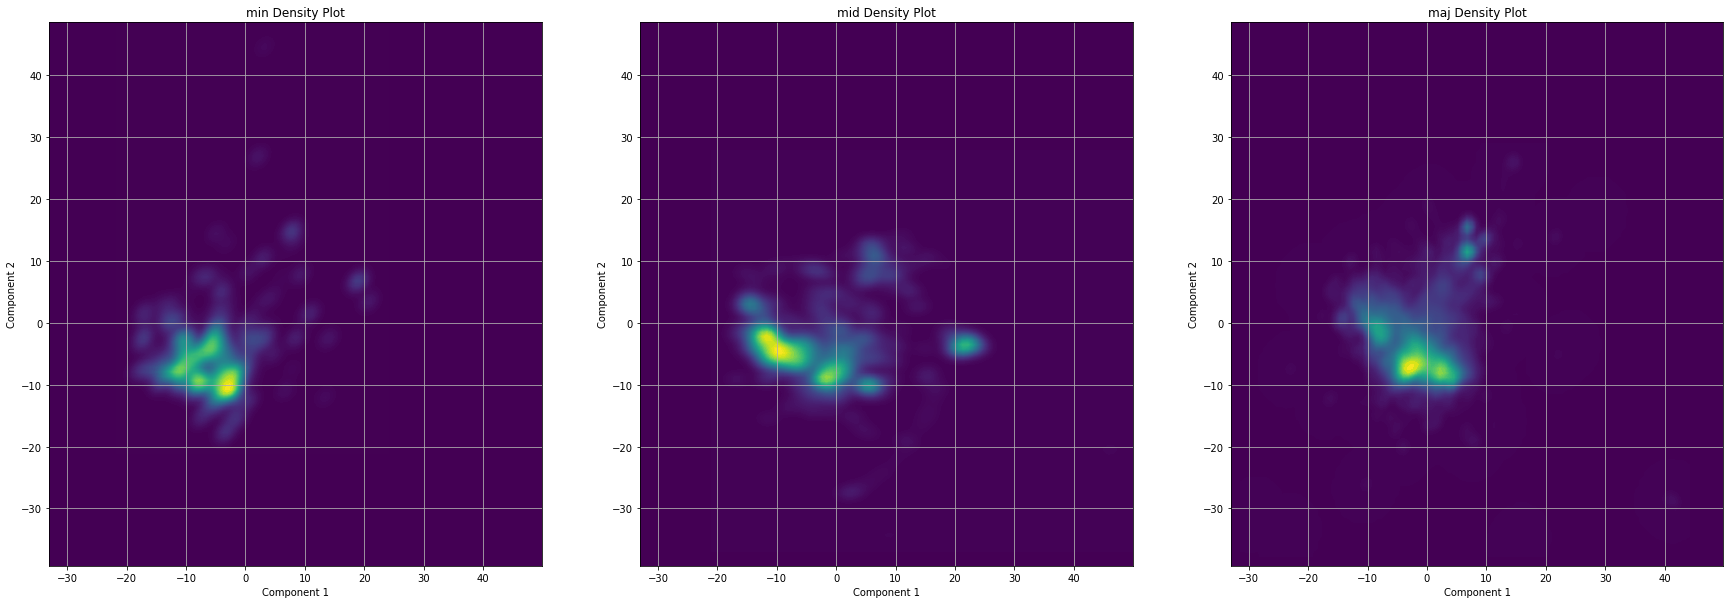

In [59]:
import seaborn as sns

# caste
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for idx, (key, cat_embed) in enumerate(caste_data.items()):
    cat_embed = np.array(cat_embed)
    print(cat_embed.shape)
    num_fr,_ = cat_embed.shape
    nan_fr,_ = np.where(np.isnan(cat_embed))
    bad_fr = np.unique(nan_fr)
    good_fr = np.array([True]*num_fr)
    good_fr[bad_fr] = False
    # density
    sns.kdeplot(x=cat_embed[good_fr,0], y=cat_embed[good_fr,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=1,
            levels=100, cmap='viridis',
            cbar=False, ax=ax[idx])
    
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#440054',
               xlim=ax_all_embed.get_xlim(), ylim=ax_all_embed.get_ylim()) # , facecolor='#000096'
    ax[idx].grid(which="major")
plt.show()

# Motif Usage

In [60]:
import collections

num_clusters = np.max(cluster) + 1
caste_motif = {"min": [], "mid": [], "maj":[]}

for key in caste_cluster.keys():
    print(key)
    
    for clust_id in np.arange(-2,num_clusters):
        clust_fr, = np.where( caste_cluster[key]==clust_id )
        caste_motif[key].append(len(clust_fr))
    
    cluster_num_fr_norm = 100*np.array(caste_motif[key])/np.sum(caste_motif[key])
    caste_motif[key] = cluster_num_fr_norm
    print(caste_motif)

min
{'min': array([0.00000000e+00, 9.42073472e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.67636885e-02, 4.15073903e-02,
       0.00000000e+00, 7.66898449e-02, 0.00000000e+00, 6.30517024e-02,
       0.00000000e+00, 0.00000000e+00, 1.06733289e-02, 5.23783735e-02,
       4.03214649e-02, 0.00000000e+00, 2.62880139e-02, 0.00000000e+00,
       1.52984381e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.23349291e-02, 0.00000000e+00, 4.96112141e-02,
       3.34035665e-02, 0.00000000e+00, 0.00000000e+00, 1.93562797e+00,
       0.00000000e+00, 7.66898449e-02, 0.00000000e+00, 1.08709832e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.00065226e-02, 2.67544779e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.77888816e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.14046496e-01, 7.70851534e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000

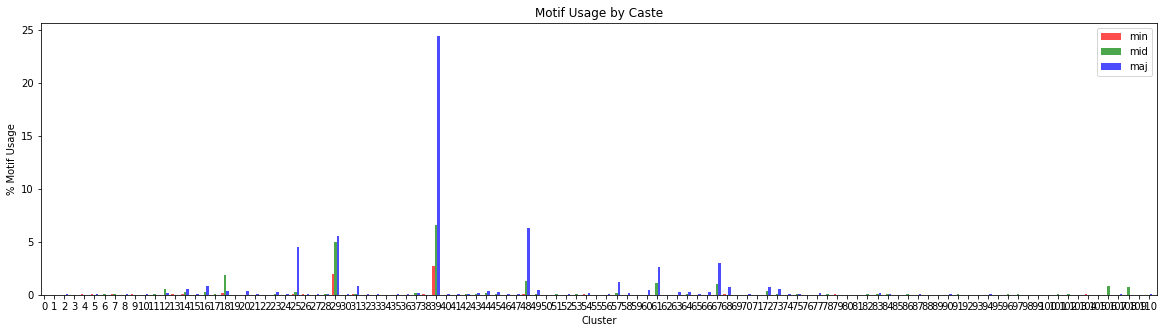

In [61]:
# Distribution figure  
cluster_id = np.arange(0,num_clusters*12)
width = 3

fig, ax = plt.subplots(figsize=(20,5)) 
ax.bar(cluster_id[0::12], caste_motif['min'][2:],color='red',width=width,label='min',alpha=0.7)
ax.bar(cluster_id[3::12], caste_motif['mid'][2:],color='green',width=width,label='mid',alpha=0.7)
ax.bar(cluster_id[6::12], caste_motif['maj'][2:],color='blue',width=width,label='maj',alpha=0.7)
ax.set(xlabel="Cluster", ylabel="% Motif Usage", title="Motif Usage by Caste", 
       xticks=cluster_id[3::12], xticklabels=np.arange(0,num_clusters).astype(int),
      xlim=[-1,num_clusters*12+1])
plt.legend()
plt.show()